# What Topics Should Candidates Address in Their 2020 Campaigns?

In [1]:
# importing all required packages
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from collections import Counter
from operator import itemgetter
import calendar
import re
import spacy 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import numpy as np
import seaborn as sns
from sklearn.manifold import TSNE
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import calinski_harabaz_score
from sklearn.mixture import GaussianMixture

## Data Cleaning and Pre-processing

In [2]:
# importing json into pandas dataframe structure
proj_df = pd.read_json('combined.json', lines=True)

# this is what our original json file looks like after importing
proj_df.head()

,components,contents,date,id,title,topics
0,[National Security Division (NSD)],"PORTLAND, Oregon. – Mohamed Osman Mohamud, 23,...",2014-10-01 04:00:00,None,Convicted Bomb Plotter Sentenced to 30 Years,[]
1,[Environment and Natural Resources Division],WASHINGTON – North Carolina’s Waccamaw River...,2012-07-25 04:00:00,12-919,$1 Million in Restitution Payments Announced t...,[]
2,[Environment and Natural Resources Division],BOSTON– A $1-million settlement has been...,2011-08-03 04:00:00,11-1002,$1 Million Settlement Reached for Natural Reso...,[]
3,[Environment and Natural Resources Division],WASHINGTON—A federal grand jury in Las Vegas...,2010-01-08 05:00:00,10-015,10 Las Vegas Men Indicted \r\nfor Falsifying V...,[]
4,[Environment and Natural Resources Division],"The U.S. Department of Justice, the U.S. Envir...",2018-07-09 04:00:00,18-898,$100 Million Settlement Will Speed Cleanup Wor...,[Environment]


In [3]:
# printing the shape of the file- there were originally 13,087 rows and 6 columns 
proj_df.shape

(13087, 6)

We are focusing only on the last two years (2017 and 2018). So, the next step is to filter our dataset to only those 2 years

In [4]:
# Filter by the latest two years (2017 and 2018)
proj_df['date'] = pd.to_datetime(proj_df['date'])
df_1718 = proj_df[proj_df['date'].dt.year >= 2017]

# resetting the index of the subsetted dataframe for ease of use
new_index = list(range(2208))
df_1718 = df_1718.set_index([pd.Index(new_index)])

# here is the subsetted dataframe
df_1718.head()

,components,contents,date,id,title,topics
0,[Environment and Natural Resources Division],"The U.S. Department of Justice, the U.S. Envir...",2018-07-09 04:00:00,18-898,$100 Million Settlement Will Speed Cleanup Wor...,[Environment]
1,"[Criminal Division, USAO - Tennessee, Middle]",A 62-count second-superseding indictment was r...,2018-03-08 05:00:00,18-285,19 Members and Associates of Tennessee Mongols...,[]
2,"[National Security Division (NSD), USAO - Cali...","Federal authorities arrested Yi-Chi Shih, 62, ...",2018-01-23 05:00:00,18-78,2 Men Charged With Conspiring to Illegally Obt...,[]
3,"[National Security Division (NSD), USAO - Cali...","Federal authorities arrested Yi-Chi Shih, 62, ...",2018-01-23 05:00:00,18-78,2 Men Charged With Conspiring to Illegally Obt...,[]
4,"[Environment and Natural Resources Division, U...",The United States Attorney’s Office for the Mi...,2017-12-14 05:00:00,17-1419,2017 Southeast Regional Animal Cruelty Prosecu...,[Environment]


Now we have 2208 rows and 6 columns. What we wish to do next is merge the 'contents' and 'title' columns to represent the content of each 'document.' The 'contents' and/or 'topics' columns will be considered our true y labels. The 'id' column will be disregarded as we do not believe it adds any value to our analysis.

In [5]:
%%time

# creating our own customized "topics" column from the components column as topics had a lot of NAs
# these will be labels used to evaluate how well we do in topic modeling and clustering 
for i, j in enumerate(df_1718.iloc[:,0]):
    if 'USAO' in j[0]:
        df_1718.iloc[i,5] = ['USAO']
    elif 'Criminal' in j[0]:
        df_1718.iloc[i,5] = ['Criminal Division']
    elif 'Civil' in j[0]:
        df_1718.iloc[i,5] = ['Civil Rights']
    elif 'General' in j[0]:
        df_1718.iloc[i,5] = ['Office of the Attorney/Solicitor General']  
    elif 'Justice' in j[0]:
        df_1718.iloc[i,5] = ['Justice Division']
    elif 'Legal' in j[0]:
        df_1718.iloc[i,5] = ['Office of Victims (Crime/Violence)']
    elif 'Victims' in j[0]:
        df_1718.iloc[i,5] = ['Office of Victims (Crime/Violence)']
    else:
        df_1718.iloc[i,5] = [j[0]]

Wall time: 1.31 s


In [6]:
# adding a new column called "documents" that includes both the content as well as the title 
# this will be used as our "documents"
df_1718['documents'] = df_1718["title"] + ' ' + df_1718["contents"] 

# printing the new table with the added columns we plan to use - topics and documents
df_1718.head()

,components,contents,date,id,title,topics,documents
0,[Environment and Natural Resources Division],"The U.S. Department of Justice, the U.S. Envir...",2018-07-09 04:00:00,18-898,$100 Million Settlement Will Speed Cleanup Wor...,Environment and Natural Resources Division,$100 Million Settlement Will Speed Cleanup Wor...
1,"[Criminal Division, USAO - Tennessee, Middle]",A 62-count second-superseding indictment was r...,2018-03-08 05:00:00,18-285,19 Members and Associates of Tennessee Mongols...,Criminal Division,19 Members and Associates of Tennessee Mongols...
2,"[National Security Division (NSD), USAO - Cali...","Federal authorities arrested Yi-Chi Shih, 62, ...",2018-01-23 05:00:00,18-78,2 Men Charged With Conspiring to Illegally Obt...,National Security Division (NSD),2 Men Charged With Conspiring to Illegally Obt...
3,"[National Security Division (NSD), USAO - Cali...","Federal authorities arrested Yi-Chi Shih, 62, ...",2018-01-23 05:00:00,18-78,2 Men Charged With Conspiring to Illegally Obt...,National Security Division (NSD),2 Men Charged With Conspiring to Illegally Obt...
4,"[Environment and Natural Resources Division, U...",The United States Attorney’s Office for the Mi...,2017-12-14 05:00:00,17-1419,2017 Southeast Regional Animal Cruelty Prosecu...,Environment and Natural Resources Division,2017 Southeast Regional Animal Cruelty Prosecu...


## Exploratory Data Analysis

In [9]:
# listing all the topics in our subsetted dataset

for i,k in enumerate(set(df_1718['topics']),1):
    print(i,k)

1 Tax Division
2 Community Oriented Policing Services (COPS)
3 Office of the Attorney/Solicitor General
4 Civil Rights
5 Drug Enforcement Administration (DEA)
6 Office on Violence Against Women
7 Office of Information Policy
8 USAO
9 Asset Forfeiture Program
10 Federal Bureau of Investigation (FBI)
11 U.S. Trustee Program
12 Justice Division
13 Bureau of Alcohol, Tobacco, Firearms and Explosives (ATF)
14 Office of Victims (Crime/Violence)
15 Environment and Natural Resources Division
16 Federal Bureau of Prisons (BOP)
17 National Security Division (NSD)
18 Antitrust Division
19 Office of Public Affairs
20 Criminal Division
21 Executive Office for Immigration Review


Text(0, 0.5, 'Raw count')

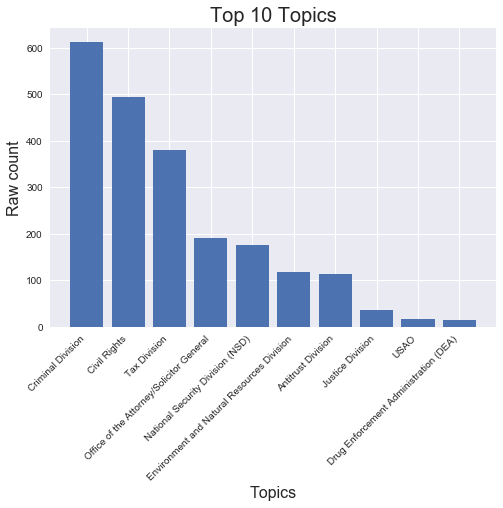

In [10]:
# Obtaining the frequency table for the topics that appears in our data
topic_counts = Counter()

for elem in df_1718['topics']:
    topic_counts[elem] += 1

# Sorting frequency table for histogram
sorted_topics = sorted(topic_counts.items(),
                                  reverse=True,
                                  key=itemgetter(1))

# graphing the top topics
%matplotlib inline
plt.style.use('seaborn')

num_top_topics = 10
items = [item for item, count in sorted_topics[:num_top_topics]]
counts = [count for item, count in sorted_topics[:num_top_topics]]
plt.bar(range(num_top_topics), counts)
plt.xticks(range(num_top_topics), items, rotation=45, ha='right')
plt.title("Top 10 Topics", fontsize = 20)
plt.xlabel('Topics', fontsize = 16)
plt.ylabel('Raw count', fontsize = 16)

Next, we will see which months had the most press releases from the DOJ. 

In [11]:
# Seeing the distribution of press releases across months, and years
date_counts = Counter()
month_counts = Counter()
year_counts = Counter()

# Creates frequency tables for month, year,and month-year 
for elem in df_1718['date']:
    m = [elem.month, elem.strftime("%B")]
    y = elem.year
    m_y = m[1] + '-' + str(y)
    date_counts[m_y] += 1
    month_counts[m[0]] += 1
    year_counts[y] += 1

#sorts month table & prints results
sorted_months = sorted(month_counts.items(),
                      key=itemgetter(0))

for token, count in sorted_months:
    print(token, ":", count, 'press releases')
print('\n')

# Prints numbers of articles for each year
for item, count in list(year_counts.items()):
    print(item, ":", count, 'press releases')

1 : 240 press releases
2 : 204 press releases
3 : 244 press releases
4 : 280 press releases
5 : 236 press releases
6 : 255 press releases
7 : 209 press releases
8 : 101 press releases
9 : 103 press releases
10 : 123 press releases
11 : 107 press releases
12 : 106 press releases


2018 : 869 press releases
2017 : 1339 press releases


Text(0, 0.5, 'Raw count')

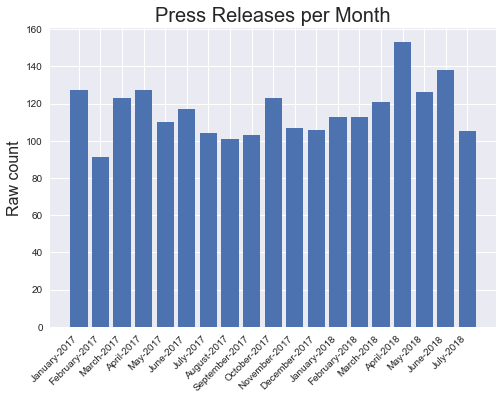

In [12]:
# Seeing the distribution of press releases across month and year combinations

# Sorting month-year list
m_y_list = []
date_list = list(date_counts.items())
sorted_indexes = [9, 11, 13, 16, 12, 17, 15, 10, 6, 5, 4, 3, 2, 14, 1, 8, 18, 7, 0]
for n in sorted_indexes:
    m_y_list.append(date_list[n])

#Graphing month-year histogram
items = [item for item, count in m_y_list]
counts = [count for item, count in m_y_list]
plt.bar(items, counts)
plt.xticks(range(len(m_y_list)), items, rotation=45, ha='right')
plt.title("Press Releases per Month", fontsize = 20)
plt.ylabel('Raw count', fontsize = 16)

## Text Analysis

### Preparing list of documents for analysis

In [13]:
# merging 'title' and 'contents' 
documents_df = df_1718["documents"] 

# converting the df to a list to run topic modeling
documents_list = list(documents_df)

# confirming number of documents is 2208
len(documents_list)

2208

### Text Analysis: Unigrams

In [14]:
# creating an nlp instance
nlp = spacy.load('en', disable=['ner', 'parser', 'tagger'])

raw_lemma_cts_nostop = Counter() # to count unigrams
all_tokens = [] # to note all tokens (will use later to get bigrams)

# counting the number of times each word appears in the corpus (2208 press releases) and build a frequency table.
for doc in documents_list:
    nlp_doc = nlp(doc)
    for token in nlp_doc:
        lemmas = token.lemma_.lower()
        if re.match('[a-zA-Z]+$', lemmas) and not (nlp.vocab[lemmas].is_stop or token.pos_ == 'PUNCT' or token.pos_ == 'SPACE'):
            raw_lemma_cts_nostop[lemmas] += 1
            all_tokens.append(lemmas)

Wall time: 55.9 s


Now that we have performed natural language processing on the press releases using spacy, it's time to see which words appeared most frequently. 

In [15]:
# sorting the table 
sorted_cts = sorted(raw_lemma_cts_nostop.items(),
                                  reverse=True,
                                  key=itemgetter(1))

# printing the top 50 most frequent words, their counts (frequencies) and ranks.
index = 1
for lem, count in sorted_cts[:50]:
    print("rank=", index, ' ', lem, ":", count)
    index += 1

rank= 1   attorney : 8978
rank= 2   department : 7443
rank= 3   district : 6269
rank= 4   division : 5781
rank= 5   justice : 5514
rank= 6   general : 4649
rank= 7   assistant : 4362
rank= 8   charge : 4117
rank= 9   office : 3952
rank= 10   criminal : 3853
rank= 11   tax : 3851
rank= 12   case : 3792
rank= 13   law : 3478
rank= 14   sentence : 3460
rank= 15   federal : 3384
rank= 16   fraud : 3292
rank= 17   acting : 3070
rank= 18   enforcement : 3031
rank= 19   guilty : 2995
rank= 20   today : 2933
rank= 21   united : 2815
rank= 22   states : 2704
rank= 23   court : 2640
rank= 24   year : 2562
rank= 25   prison : 2542
rank= 26   defendant : 2512
rank= 27   use : 2506
rank= 28   investigation : 2503
rank= 29   service : 2412
rank= 30   fbi : 2373
rank= 31   include : 2351
rank= 32   information : 2315
rank= 33   new : 2264
rank= 34   trial : 2253
rank= 35   pay : 2236
rank= 36   indictment : 2205
rank= 37   return : 2188
rank= 38   provide : 2156
rank= 39   state : 2127
rank= 40   age

Next, we will plot the top 20 words and their frequencies (raw counts).

Text(0, 0.5, 'Raw Count')

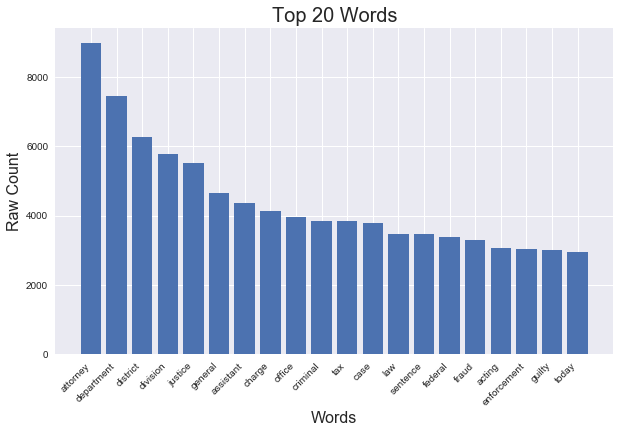

In [16]:
# plotting the top 20 unigrams and their frequencies

num_top_words = 20
items = [item for item, count in sorted_cts[:num_top_words]]
counts = [count for item, count in sorted_cts[:num_top_words]]

plt.figure(figsize=(10,6))
plt.bar(range(num_top_words), counts)
plt.xticks(range(num_top_words), items, rotation=45, ha='right')
plt.title("Top 20 Words", fontsize = 20)
plt.xlabel('Words', fontsize = 16)
plt.ylabel('Raw Count', fontsize = 16)

### Text Analysis: Bigrams

In [17]:
# counting all bigrams
bigram_counter=Counter()

for i in list(range(len(all_tokens)-1)):
    bigram = " ".join(all_tokens[i:i+2])
    bigram_counter[bigram]+=1

In [18]:
# sorting the table
sorted_bigram_cts = sorted(bigram_counter.items(),
                                  reverse=True,
                                  key=itemgetter(1))

# printing the top 50 most frequent bigrams, their counts (frequencies) and ranks
index = 1
for lem, count in sorted_bigram_cts[:50]:
    print("rank=", index, ' ', lem, ":", count)
    index += 1

rank= 1   attorney general : 3806
rank= 2   assistant attorney : 3432
rank= 3   justice department : 2771
rank= 4   united states : 2671
rank= 5   department justice : 1788
rank= 6   law enforcement : 1686
rank= 7   plead guilty : 1670
rank= 8   acting assistant : 1582
rank= 9   special agent : 1579
rank= 10   criminal division : 1532
rank= 11   new york : 1252
rank= 12   agent charge : 1134
rank= 13   tax return : 1118
rank= 14   tax division : 1113
rank= 15   eastern district : 1083
rank= 16   trial attorney : 976
rank= 17   southern district : 909
rank= 18   supervise release : 899
rank= 19   prosecute case : 896
rank= 20   attorney office : 850
rank= 21   year prison : 823
rank= 22   deputy assistant : 820
rank= 23   district court : 742
rank= 24   civil rights : 714
rank= 25   field office : 702
rank= 26   acting attorney : 702
rank= 27   health care : 681
rank= 28   rights division : 654
rank= 29   national security : 647
rank= 30   department criminal : 635
rank= 31   co conspir

Text(0, 0.5, 'Raw Count')

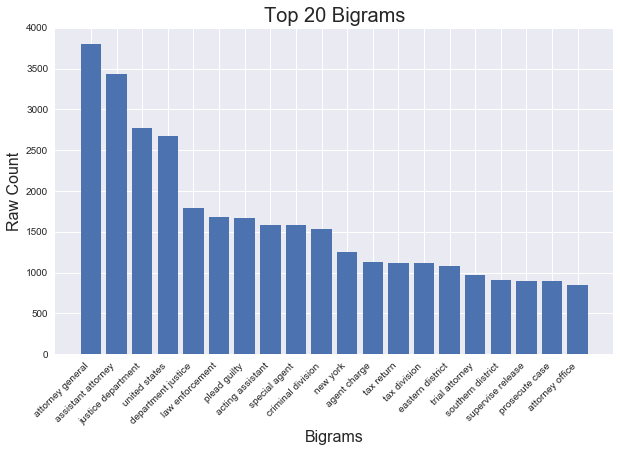

In [19]:
# plotting the top / most frequent bigrams
num_top_bigrams = 20
items = [item for item, count in sorted_bigram_cts[:num_top_bigrams]]
counts = [count for item, count in sorted_bigram_cts[:num_top_bigrams]]

plt.figure(figsize=(10,6))
plt.bar(range(num_top_bigrams), counts)
plt.xticks(range(num_top_bigrams), items, rotation=45, ha='right')
plt.title("Top 20 Bigrams", fontsize = 20)
plt.xlabel('Bigrams', fontsize = 16)
plt.ylabel('Raw Count', fontsize = 16)

## TOPIC MODELING

### Topic Modeling with Unigrams

In [20]:
# processing the unigrams using CountVectorizer
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=50, stop_words='english') 
tf = tf_vectorizer.fit_transform(documents_list)

Wall time: 1.26 s


In [21]:
# here are the number of unique unigrams in our vocabulary
unique_vocabulary = list(tf_vectorizer.vocabulary_.keys())
print("The number of unique words in the vocabulary is:", len(unique_vocabulary)) 

The number of unique words in the vocabulary is: 1694


In [30]:
# using LDA for topic modeling with unigrams
num_topics = 10

# creating an LDA instance
lda = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=94775)

# fitting the unigram term-frequency matrix using LDA
lda.fit(tf)

Wall time: 20 s


In [31]:
# confirming that we have 10 topics and 1694 words per topic
lda.components_.shape

(10, 1694)

In [32]:
# obtaining the distribution of words for each topic
topic_word_distributions = np.array([topic_word_pseudocounts / np.sum(topic_word_pseudocounts)
                                     for topic_word_pseudocounts in lda.components_])

# printing the top 10 words per topic, for all 10 topics
num_top_words = 10

print('Displaying the top %d words per topic and their probabilities within the topic...' % num_top_words)
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_word_distributions[topic_idx])[::-1]
    for rank in range(num_top_words):
        word_idx = sort_indices[rank]
        print(tf_vectorizer.get_feature_names()[word_idx], ':', round(topic_word_distributions[topic_idx, word_idx]*100,4),"%")
    print()

Displaying the top 10 words per topic and their probabilities within the topic...

[Topic 0]
immigration : 4.1489 %
general : 2.915 %
states : 2.3341 %
security : 2.2813 %
united : 2.1697 %
sessions : 1.9585 %
justice : 1.9308 %
ms : 1.6629 %
13 : 1.5526 %
law : 1.4212 %

[Topic 1]
drug : 2.127 %
enforcement : 1.5565 %
fraud : 1.2982 %
justice : 1.1467 %
said : 1.1245 %
western : 1.0674 %
antitrust : 1.04 %
drugs : 1.0289 %
district : 0.9977 %
law : 0.932 %

[Topic 2]
child : 2.9382 %
sexual : 2.4007 %
district : 1.9107 %
victims : 1.7772 %
justice : 1.6359 %
children : 1.5519 %
trafficking : 1.4258 %
case : 1.3663 %
pornography : 1.3058 %
exploitation : 1.2795 %

[Topic 3]
health : 2.9936 %
fraud : 2.4336 %
medicare : 2.3693 %
care : 2.0467 %
claims : 1.9286 %
services : 1.6592 %
million : 1.4197 %
office : 1.3738 %
false : 1.3028 %
general : 1.1389 %

[Topic 4]
district : 1.8597 %
criminal : 1.7293 %
guilty : 1.6286 %
division : 1.4546 %
assistant : 1.2991 %
case : 1.2565 %
office : 

We are thrilled by the results. We can clearly see distinct topics as follows:

 - Topic 0 refers to immigration issues, push factors such as gangs in Central American countries (i.e. MS13) and border security.
 - Topic 1 refers to drug issues and enforcement of drug laws. This topic likely correlates to Topic 0 on border security.
 - Topic 2 discusses sex trafficking and other sexual crimes.
 - Topic 3 is related to healthcare.
 - Topic 4 refers to crime more generally and the recent indictments around various groups (i.e. FBI).
 - Topic 5 corresponds to civil rights, justice and discrimination.
 - Topic 6 is again more general and discusses settlements.
 - Topic 7 refers to taxation, income and the IRS.
 - Topic 8 corresponds to harsh crimes involving prison.
 - Topic 9 discusses law enforcement and clashes with civil rights.

### Visualizing the unigram topic modeling results in 2-D using t-SNE

In [35]:
# transforming the unigram term-frequency matrix
# so now we have the matrix of 2208 documents by the 10 topics
doc_topic_distribs = lda.transform(tf)
doc_topic_distribs.shape 

Wall time: 1.51 s


In [36]:
# determining the which topic each document would have the highest probability of being assigned to 
prob_topic_assign = []
for app in doc_topic_distribs:
    prob = app.argmax()
    prob_topic_assign.append(prob)

In [38]:
# creating a tsne instance
tsne = TSNE(n_components=2, random_state=94775, init='pca', angle=0.99, n_iter=5000)  

# fitting and transforming the above created doc_topic_distribs data
doc_topic_prop_tsne_2d = tsne.fit_transform(doc_topic_distribs)

Wall time: 1min


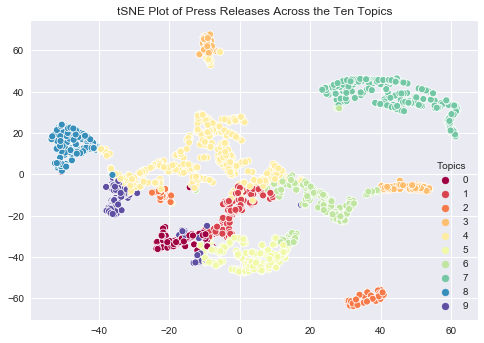

In [39]:
# plotting the 2-d representation of the our topic modeling results (unigrams) using tsne
ax = sns.scatterplot(x=doc_topic_prop_tsne_2d[:, 0], y=doc_topic_prop_tsne_2d[:, 1], hue=prob_topic_assign, legend="full",
                    palette="Spectral")
plt.legend(title="Topics")
plt.title("tSNE Plot of Press Releases Across the Ten Topics")
plt.show()

Press releases most likely to fall in topic 2 appear to be easily clustered and separated from other topics. This is not surprising since this topic seems to clearly refer to sex trafficking. This topic is not as connected to other topics. Additionally, topic 7 is pretty clearly separate from the other topics. This is also not surprising since it quite clearly refers to taxation. 

Topic 9 seems to mix with other topics in the plot. This is not surprising either since it is a bit more general, encompassing law enforcement and rights.

### Topic Modeling with Bigrams

In [25]:
%%time

# processing the bigrams using CountVectorizer
tf_vectorizer_bigrams = CountVectorizer(max_df=0.95, min_df=50, stop_words='english', ngram_range=(2,2)) #set these based on LDA demo with news reports
tf_bigrams = tf_vectorizer_bigrams.fit_transform(documents_list)

Wall time: 4.08 s


In [26]:
# here are the number of unique bigrams in our vocabulary
unique_vocabulary_bigrams = list(tf_vectorizer_bigrams.vocabulary_.keys())
print("The number of unique words in the vocabulary is:", len(unique_vocabulary_bigrams)) #cool!

The number of unique words in the vocabulary is: 698


In [33]:
%%time

# using LDA for topic modeling with bigrams
num_topics = 10

# creating an LDA instance for bigrams
lda_bigrams = LatentDirichletAllocation(n_components=num_topics, learning_method='online', random_state=94775)

# fitting the bigram term-frequency matrix with LDA instance for bigrams
lda_bigrams.fit(tf_bigrams)

Wall time: 6.14 s


In [34]:
# obtaining the distribution of bigrams for each topic

topic_bigrams_distributions = np.array([topic_bigram_pseudocounts / np.sum(topic_bigram_pseudocounts)
                                     for topic_bigram_pseudocounts in lda_bigrams.components_])

# printing the top 10 bigrams per topic, for all 10 topics
num_top_bigrams = 10

print('Displaying the top %d bigrams per topic and their probabilities within the topic...' % num_top_bigrams)
print()

for topic_idx in range(num_topics):
    print('[Topic ', topic_idx, ']', sep='')
    sort_indices = np.argsort(topic_bigrams_distributions[topic_idx])[::-1]
    for rank in range(num_top_bigrams):
        bigram_idx = sort_indices[rank]
        print(tf_vectorizer_bigrams.get_feature_names()[bigram_idx], ':', round(topic_bigrams_distributions[topic_idx, bigram_idx]*100,4),"%")
    print()

Displaying the top 10 bigrams per topic and their probabilities within the topic...

[Topic 0]
united states : 4.5382 %
department justice : 3.0205 %
justice department : 2.9324 %
false claims : 2.6636 %
civil division : 2.4372 %
antitrust division : 2.2915 %
assistant attorney : 1.9637 %
attorney general : 1.7444 %
said acting : 1.7171 %
inspector general : 1.6912 %

[Topic 1]
criminal division : 4.1113 %
pleaded guilty : 2.2652 %
assistant attorney : 2.034 %
fraud section : 1.9162 %
special agent : 1.9091 %
agent charge : 1.8598 %
health care : 1.7272 %
southern district : 1.6442 %
department criminal : 1.5371 %
justice department : 1.5284 %

[Topic 2]
tax division : 4.4872 %
tax returns : 3.8193 %
assistant attorney : 3.2973 %
acting deputy : 2.7316 %
deputy assistant : 2.6483 %
attorney general : 2.5831 %
internal revenue : 1.5561 %
tax return : 1.5437 %
income tax : 1.4953 %
general goldberg : 1.465 %

[Topic 3]
police department : 2.3432 %
presumed innocent : 2.1194 %
assistant a

### Visualizing the bigram topic modeling results in 2-D using t-SNE

In [41]:
# transforming the bigram term-frequency matrix
doc_topic_distribs_bigrams = lda_bigrams.transform(tf_bigrams)

In [42]:
# determining the which topic each document would have the highest probability of being assigned to 
prob_topic_assign_bigrams = []
for app in doc_topic_distribs_bigrams:
    prob = app.argmax()
    prob_topic_assign_bigrams.append(prob)

In [43]:
# creating tsne instance for bigrams data
tsne_bigrams = TSNE(n_components=2, random_state=94775, init='pca', angle=0.99, n_iter=5000)  

# fitting and transforming bigram data using the tsne instance
doc_topic_prop_tsne_2d_bigrams = tsne_bigrams.fit_transform(doc_topic_distribs_bigrams)

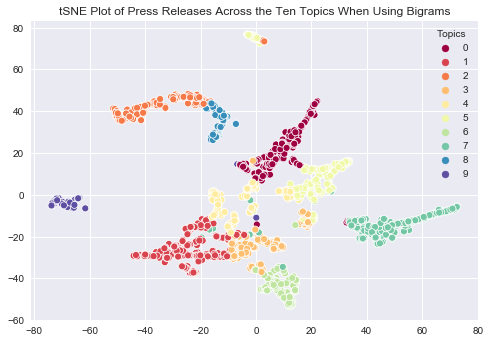

In [44]:
# plotting the 2-d representation of the our topic modeling results (bigrams) using tsne
ax_bigrams = sns.scatterplot(x=doc_topic_prop_tsne_2d_bigrams[:, 0], y=doc_topic_prop_tsne_2d_bigrams[:, 1], 
                             hue=prob_topic_assign_bigrams, legend="full", palette="Spectral")
plt.legend(title="Topics")
plt.title("tSNE Plot of Press Releases Across the Ten Topics When Using Bigrams")
plt.show()

## Sentiment Analysis

Next, we did sentiment analysis using TextBlob. The sentiment property returns a namedtuple of the form Sentiment(polarity, subjectivity). The polarity score is a float within the range [-1.0, 1.0]. If the polarity is negative, it shows that content is negative. The subjectivity is a float within the range [0.0, 1.0] where 0.0 is very objective and 1.0 is very subjective. 


In [45]:
#Adding a column in the dataframe for the polarity and subjectivity
df_1718['polarity'] = df_1718['documents'].apply(lambda x: TextBlob(x).sentiment.polarity)
df_1718['subjectivity'] = df_1718['documents'].apply(lambda x: TextBlob(x).sentiment.subjectivity)

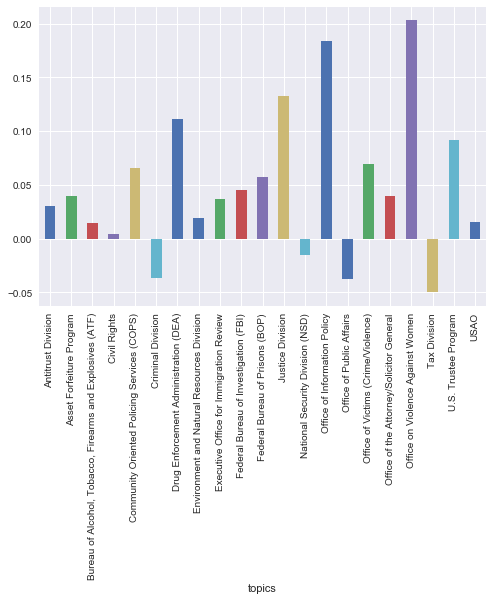

In [46]:
# plotting polarity
df_1718.groupby(df_1718.iloc[:,5])['polarity'].mean().plot.bar()

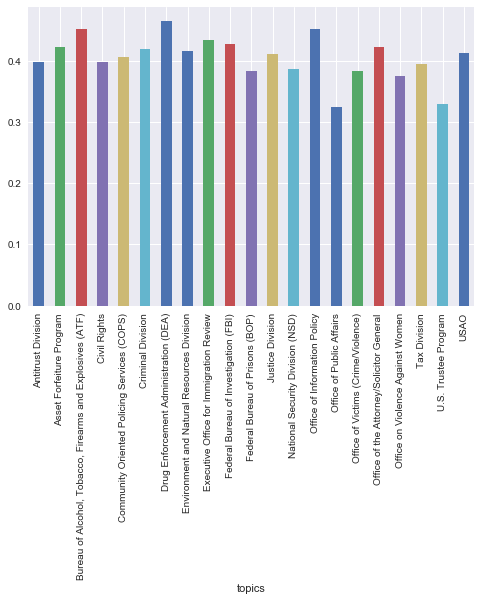

In [47]:
# plotting subjectivity
df_1718.groupby(df_1718.iloc[:,5])['subjectivity'].mean().plot.bar()

## Clustering the Press Releases Using Gaussian Mixture Modeling

### Clustering using Unigrams

In [49]:
# creating an instance of the vectorizer
# normalizing the data 
vectorizer = TfidfVectorizer(max_df=0.95, min_df=50, stop_words='english')

# using the instance to construct a normalized document matrix X
X = vectorizer.fit_transform(documents_list)
X = X.toarray()

In [ ]:
%%time

# running a loop to determine the best number of clusters for GMM
best_score = -np.inf
best_k = None
best_model = None
best_cluster_assignments = None

# see which number of clusters has highest CH index
for k in range(2, 6):
    candidate_gmm = GaussianMixture(n_components=k, n_init=100, random_state=94775)
    candidate_gmm.fit(X)
    cluster_assignments = candidate_gmm.predict(X)
    score = calinski_harabaz_score(X, cluster_assignments)
    
    print('k =', k, 'has CH index', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = candidate_gmm
        best_cluster_assignments = cluster_assignments
    
print('Best k within 2, 3, ..., 10 according to CH index:', best_k)

In [50]:
# fitting and predicting our normalized unigram data using the best number of clusters determined in the loop above
best_unigram_gmm = GaussianMixture(n_components=3, n_init=100, random_state=94775)
best_unigram_gmm.fit(X)
best_unigram_cluster_assignments = best_unigram_gmm.predict(X)

In [51]:
assignments = Counter()

# looping over each cluster assignment
# counting the number of assignments per cluster
for item in list(best_unigram_cluster_assignments):
        assignments[item] += 1 

# printing the number of documents assigned to each cluster
print("Cluster", "# of Documents")
for k, v in assignments.items(): 
    print(str(k).ljust(10), str(v))

Cluster # of Documents
2          875
0          957
1          376


In [59]:
# getting the indices of the original data for each of the clusters
get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
cluster0 = get_indexes(0,best_unigram_cluster_assignments)
cluster1 = get_indexes(1,best_unigram_cluster_assignments)
cluster2 = get_indexes(2,best_unigram_cluster_assignments)

# counting the frequency of each topic within each cluster
comp_cluster0 = Counter()
comp_cluster1 = Counter()
comp_cluster2 = Counter()

for i in df_1718.loc[cluster0, "topics"]:
    comp_cluster0[i]+=1
        
for i in df_1718.loc[cluster1, "topics"]:
    comp_cluster1[i]+=1

for i in df_1718.loc[cluster2, "topics"]:
    comp_cluster2[i]+=1

# sorting the frequencies in descending order
sorted_cluster0 = sorted(comp_cluster0.items(),
                                  reverse=True,
                                  key=itemgetter(1))

sorted_cluster1 = sorted(comp_cluster1.items(),
                                  reverse=True,
                                  key=itemgetter(1))


sorted_cluster2 = sorted(comp_cluster2.items(),
                                  reverse=True,
                                  key=itemgetter(1))

# printing the top 10 topics per cluster
print("Top 10 Topics in Cluster 0 (Unigrams):")
for k, v in sorted_cluster0[0:10]: 
    print(str(k).ljust(55), str(v))

print( )

print("Top 10 Topics in Cluster 1 (Unigrams):")
for k, v in sorted_cluster1[0:10]: 
    print(str(k).ljust(55), str(v))
    
print( )

print("Top 10 Topics in Cluster 2 (Unigrams):")
for k, v in sorted_cluster2[0:10]: 
    print(str(k).ljust(55), str(v))
    

Top 10 Topics in Cluster 0 (Unigrams):
Criminal Division                                       257
Civil Rights                                            208
Office of the Attorney/Solicitor General                181
National Security Division (NSD)                        163
Environment and Natural Resources Division              40
Justice Division                                        35
Drug Enforcement Administration (DEA)                   13
USAO                                                    12
Executive Office for Immigration Review                 11
Federal Bureau of Investigation (FBI)                   8

Top 10 Topics in Cluster 1 (Unigrams):
Tax Division                                            374
Asset Forfeiture Program                                2

Top 10 Topics in Cluster 2 (Unigrams):
Criminal Division                                       355
Civil Rights                                            285
Antitrust Division                                

TSNE 2-dim representation show that cluster==1 is the most clearly separated from the other 2. Cluster==0 & 2 are slightly intertwined whereas cluster==1 is pertains solely to Tax and USAO.

### t-SNE to visualize clustering results for unigrams

In [60]:
# creating tsne instance
tsne = TSNE(n_components=2, random_state=94775, init='pca', angle=0.99, n_iter=5000)

# fitting and transforming normalized unigram tf matrix
X_tsne2d = tsne.fit_transform(X)

(-79.59279851742544, 97.35295324154654, -76.19970973423949, 70.52916606358521)

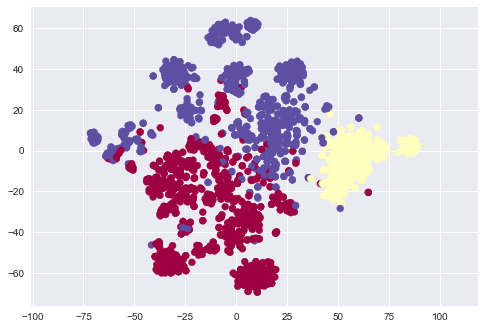

In [61]:
# plotting the 2-d representation of clustering results with unigrams
plt.scatter(X_tsne2d[:, 0], X_tsne2d[:, 1], c=best_unigram_cluster_assignments, cmap='Spectral')
plt.axis('equal')

### Clustering using Bigrams

In [62]:
# creating an instance of the vectorizer
vectorizer_bigrams = TfidfVectorizer(max_df=0.95, min_df=50, stop_words='english', ngram_range=(2,2))

# using the instance to construct a document matrix X
X_bigrams = vectorizer_bigrams.fit_transform(documents_list)
X_bigrams = X_bigrams.toarray()

In [ ]:
%%time

# running a loop to determine the best number of clusters for GMM
best_score = -np.inf
best_k = None
best_model = None
best_cluster_assignments = None

# see which number of clusters has highest CH index
for k in range(2, 6):
    candidate_gmm = GaussianMixture(n_components=k, n_init=100, random_state=94775)
    candidate_gmm.fit(X_bigrams)
    cluster_assignments = candidate_gmm.predict(X_bigrams)
    score = calinski_harabaz_score(X_bigrams, cluster_assignments)
    
    print('k =', k, 'has CH index', score)
    
    if score > best_score:
        best_score = score
        best_k = k
        best_model = candidate_gmm
        best_cluster_assignments_bigrams = cluster_assignments
    
print('Best k within 2, 3, ..., 10 according to CH index:', best_k)

In [68]:
# fitting and predicting our normalized unigram data using the best number of clusters determined in the loop above
best_bigram_gmm = GaussianMixture(n_components=3, n_init=100, random_state=94775)
best_bigram_gmm.fit(X_bigrams)
best_bigram_cluster_assignments = best_bigram_gmm.predict(X_bigrams)

In [69]:
assignments_bigrams = Counter()

# looping over each cluster assignment
# counting the number of assignments per cluster
for item in list(best_bigram_cluster_assignments):
        assignments_bigrams[item] += 1 

# printing the number of documents assigned to each cluster
print("Cluster", "# of Documents")
for k, v in assignments_bigrams.items(): 
    print(str(k).ljust(10), str(v))

Cluster # of Documents
2          875
0          957
1          376


In [70]:
# getting the indices of the original data for each of the clusters
cluster0_b = get_indexes(0,best_bigram_cluster_assignments)
cluster1_b = get_indexes(1,best_bigram_cluster_assignments)
cluster2_b = get_indexes(2,best_bigram_cluster_assignments)

# counting the frequency of each topic within each cluster
bigram_cluster0 = Counter()
bigram_cluster1 = Counter()
bigram_cluster2 = Counter()

for i in df_1718.loc[cluster0_b, "topics"]:
    bigram_cluster0[i]+=1
        
for i in df_1718.loc[cluster1_b, "topics"]:
    bigram_cluster1[i]+=1

for i in df_1718.loc[cluster2_b, "topics"]:
    bigram_cluster2[i]+=1

# sorting the frequencies 
sorted_bigram_cluster0 = sorted(bigram_cluster0.items(),
                                  reverse=True,
                                  key=itemgetter(1))

sorted_bigram_cluster1 = sorted(bigram_cluster1.items(),
                                  reverse=True,
                                  key=itemgetter(1))

sorted_bigram_cluster2 = sorted(bigram_cluster2.items(),
                                  reverse=True,
                                  key=itemgetter(1))

# printing the top topics for each cluster using bigrams
print("Top 10 Topics in Cluster 0 (Bigrams):")
for k, v in sorted_bigram_cluster0[0:10]: 
    print(str(k).ljust(55), str(v))

print( )

print("Top 10 Topics in Cluster 1 (Bigrams):")
for k, v in sorted_bigram_cluster1[0:10]: 
    print(str(k).ljust(55), str(v))
    
print( )

print("Top 10 Topics in Cluster 2 (Bigrams):")
for k, v in sorted_bigram_cluster2[0:10]: 
    print(str(k).ljust(55), str(v))

Top 10 Topics in Cluster 0 (Bigrams):
Criminal Division                                       257
Civil Rights                                            208
Office of the Attorney/Solicitor General                181
National Security Division (NSD)                        163
Environment and Natural Resources Division              40
Justice Division                                        35
Drug Enforcement Administration (DEA)                   13
USAO                                                    12
Executive Office for Immigration Review                 11
Federal Bureau of Investigation (FBI)                   8

Top 10 Topics in Cluster 1 (Bigrams):
Tax Division                                            374
Asset Forfeiture Program                                2

Top 10 Topics in Cluster 2 (Bigrams):
Criminal Division                                       355
Civil Rights                                            285
Antitrust Division                                   

### t-SNE to visualize clustering results for bigrams

In [66]:
# creating t-sne instance
tsne_bigrams = TSNE(n_components=2, random_state=94775, init='pca', angle=0.99, n_iter=5000)

# fitting and transforming normalized bigram tf matrix
X_tsne2d_bigrams = tsne_bigrams.fit_transform(X_bigrams)

(-86.67686490841665, 72.11186246701041, -80.73038409642211, 63.925509676256105)

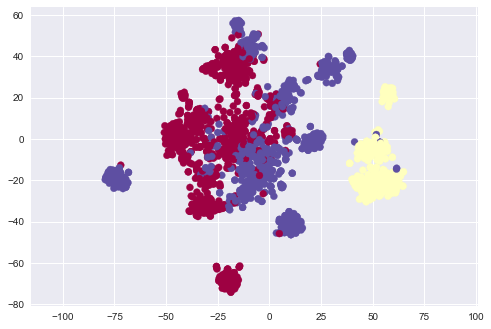

In [67]:
# plotting the 2-d representation of clustering results with bigrams
plt.scatter(X_tsne2d_bigrams[:, 0], X_tsne2d_bigrams[:, 1], c=best_bigram_cluster_assignments, cmap='Spectral')
plt.axis('equal')